In [1]:
!nvidia-smi

import os
from google.colab import drive

drive.mount('/content/gdrive')

work_root = "/content/gdrive/My Drive/cigarette_butt_segmentation"
%cd "$work_root"
data_root = '/content/data'
if not os.path.exists(data_root):
    !unzip data/cig_butts.zip -d $data_root
    !mv $data_root/cig_butts/* $data_root
    !rm -r $data_root/cig_butts 
out_dir = work_root + '/results'
weights_file_name_templ = out_dir + '/CigHeadWeights_Epoch%d.h5'

if 0:       # Warning: one-time operation, then the sources are supposed to be edited
    %cd /content
    !git clone https://github.com/pytorch/vision.git
    %cd vision
    !git checkout v0.3.0

    target_dir = work_root + "/lib/detection"
    %mkdir "$target_dir"
    # # !cp references/detection/utils.py ../
    # # !cp references/detection/transforms.py ../
    # !cp references/detection/coco_eval.py "$work_root/lib/torchvision/"
    # !cp references/detection/engine.py "$work_root/lib/torchvision/"
    # # !cp references/detection/coco_utils.py ../
    !cp references/detection/*.py "$target_dir/"

    %cd $work_root

Sun Oct  4 15:18:34 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.23.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   52C    P8    10W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [51]:
import cv2
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from PIL import ImageFile
from glob import glob

from lib import *
from lib.net import *

# from lib.torchvision.transforms1 import get_transform
# from lib.torchvision import train
# from lib.torchvision import engine
# from lib.torchvision.utils import *

# %ls -l lib/detection/
import lib.detection.transforms
from lib.detection.transforms import get_transform
from lib.detection import train
from lib.detection import engine
from lib.detection.det_utils import *

%matplotlib inline

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [52]:
# import torchvision.models.segmentation as segmentation

# # model = segmentation.deeplabv3_resnet50(True, True, 2)
#     # Fails because it is pretrained on 21 classes

# import torchvision
# from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
 
# # load a model pre-trained on COCO
# model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

# # replace the classifier with a new one, that has
# # num_classes which is user-defined
# num_classes = 2  # 1 class (person) + background
# # get number of input features for the classifier
# in_features = model.roi_heads.box_predictor.cls_score.in_features
# # replace the pre-trained head with a new one
# model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [53]:
dataset = CigDataset(data_root + '/train', get_transform(train=True))
dataset_test = CigDataset(data_root + '/val', get_transform(train=False))

# split the dataset in train and test set
torch.manual_seed(1)
# indices = torch.randperm(len(dataset)).tolist()
# dataset = torch.utils.data.Subset(dataset, indices[:-50])
# dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=8, shuffle=True, num_workers=4,
    collate_fn=collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=4,
    collate_fn=collate_fn)

# dataset[0]

2000 images
200 images


[394 245 435 323]
[394 245 435 323] - [414 128 455 206] intersection: [ 21 -39]
cur (512, 512)


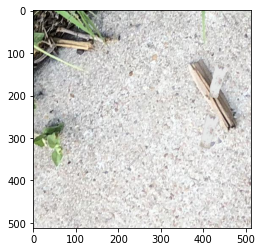

[394 245 435 323]
[394 245 435 323] - [192  84 233 162] intersection: [-161  -83]
cur (512, 512)


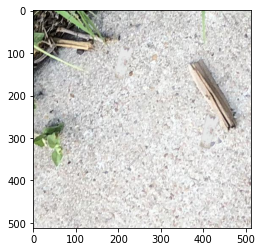

[394 245 435 323]
[394 245 435 323] - [244 210 285 288] intersection: [-109   43]
cur (512, 512)


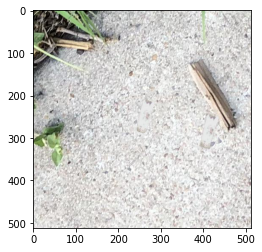

[366 267 405 317]
[366 267 405 317] - [372 292 411 342] intersection: [33 25]
[366 267 405 317] - [216 173 255 223] intersection: [-111  -44]
cur (512, 512)


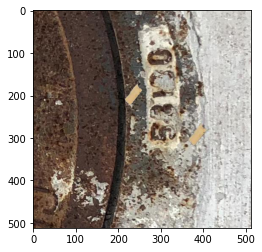

[366 267 405 317]
[366 267 405 317] - [356 300 395 350] intersection: [29 17]
[366 267 405 317] - [404 309 443 359] intersection: [1 8]
[366 267 405 317] - [347 213 386 263] intersection: [20 -4]
cur (512, 512)


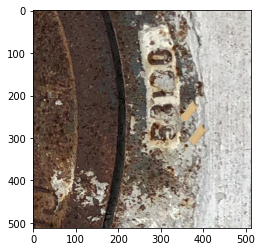

[366 267 405 317]
[366 267 405 317] - [ 65 303 104 353] intersection: [-262   14]
cur (512, 512)


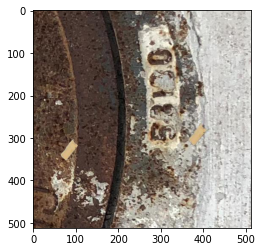

[ 78 163 177 237]
[ 78 163 177 237] - [228 195 327 269] intersection: [-51  42]
cur (512, 512)


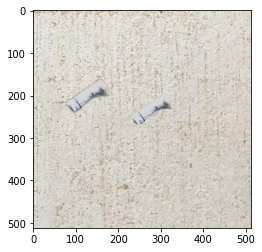

[ 78 163 177 237]
[ 78 163 177 237] - [ 59 318 158 392] intersection: [ 80 -81]
cur (512, 512)


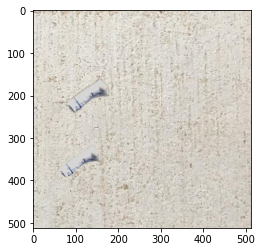

[ 78 163 177 237]
[ 78 163 177 237] - [118 335 217 409] intersection: [ 59 -98]
cur (512, 512)


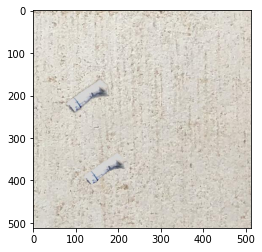

In [54]:
for i in range(9):
    img, target = dataset[i // 3 + 1]
    plt.imshow(np.transpose(img, (1, 2, 0)))
    plt.show()

In [55]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

num_classes = 2
model = get_instance_segmentation_model(num_classes, True)
model.to(device)
# criterion = train.get_criterion()
epochNum = 0

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

In [57]:
# save_model_state(model.roi_heads.mask_predictor, weights_file_name_templ % epochNum)
# save_model_state(model, (weights_file_name_templ % epochNum) + '_full')   # 
epochNum = 45
load_model_state(model.roi_heads.mask_predictor, weights_file_name_templ % epochNum)
load_model_state(model, (weights_file_name_templ % 34) + '_full')  

State loaded from /content/gdrive/My Drive/cigarette_butt_segmentation/results/CigHeadWeights_Epoch45.h5 (<All keys matched successfully>)
State loaded from /content/gdrive/My Drive/cigarette_butt_segmentation/results/CigHeadWeights_Epoch34.h5_full (<All keys matched successfully>)


{}

In [ ]:
num_epochs = 100

learnRate = 0.003
for epoch in range(num_epochs):
    for g in optimizer.param_groups:
        g['lr'] = learnRate
    train.train_one_epoch(model, optimizer, data_loader, device, epochNum, 
                          print_freq=10, printFunc=printProgress)
    # train.train_one_epoch(model, train.criterion, optimizer, data_loader, lr_scheduler, device,
    #                       epochNum, print_freq=10)
    # lr_scheduler.step()
    
    epochNum += 1
    if epochNum % 5 == 0:
        save_model_state(model.roi_heads.mask_predictor, weights_file_name_templ % epochNum)
        save_model_state(model, (weights_file_name_templ % epochNum) + '_full') 
    train.evaluate(model, data_loader_test, device=device, printFunc=printProgress)    
    
    if epochNum % 5 == 0:
        learnRate /= 5    

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "


Epoch: [45]  [  0/250]  eta: 0:12:00  lr: 0.003000  loss: 0.0963 (0.0963)  loss_classifier: 0.0112 (0.0112)  loss_box_reg: 0.0207 (0.0207)  loss_mask: 0.0641 (0.0641)  loss_objectness: 0.0001 (0.0001)  loss_rpn_box_reg: 0.0004 (0.0004)  time: 2.8827  data: 0.9033  max mem: 10698
Epoch: [45]  [ 10/250]  eta: 0:07:58  lr: 0.003000  loss: 0.1105 (0.1103)  loss_classifier: 0.0138 (0.0140)  loss_box_reg: 0.0286 (0.0274)  loss_mask: 0.0682 (0.0682)  loss_objectness: 0.0002 (0.0003)  loss_rpn_box_reg: 0.0004 (0.0005)  time: 1.9938  data: 0.1075  max mem: 10936
Epoch: [45]  [ 20/250]  eta: 0:07:27  lr: 0.003000  loss: 0.1073 (0.1079)  loss_classifier: 0.0129 (0.0131)  loss_box_reg: 0.0272 (0.0269)  loss_mask: 0.0661 (0.0672)  loss_objectness: 0.0001 (0.0002)  loss_rpn_box_reg: 0.0004 (0.0004)  time: 1.8992  data: 0.0283  max mem: 10936
Epoch: [45]  [ 30/250]  eta: 0:07:03  lr: 0.003000  loss: 0.1066 (0.1083)  loss_classifier: 0.0129 (0.0135)  loss_box_reg: 0.0250 (0.0266)  loss_mask: 0.0661 (0

# Анализ получившейся сети

In [ ]:
print('Dices mean: %.5f' % np.mean(dices))

In [61]:
img_idxs = range(100)  # sorted_dice_inds[:10]
rowCount = 1 # len(img_idxs)
colCount = 4
log_thresholds = [0.1, 0.3, 0.5, 0.7, 0.95]
threshold_to_use_ind = 2
model.eval()
dices = []
with torch.no_grad():
    for img_idx2, img_idx in enumerate(img_idxs):
        img, target = dataset[img_idx]
        images = images_to_device(img, device)
        targets = targets_to_device(target, device)
        pred = model(images)
        masks = pred[0]['masks'].cpu()

        mask_count = masks.shape[0]
        cur_dices = []
        for threshold in [0.1, 0.3, 0.5, 0.7, 0.95]:
            if mask_count != 0:
                dice = get_dice(target['masks'][0].numpy().astype(bool),
                                masks[0, 0].numpy() > threshold) / mask_count
                    # Некоторая вариация метрики - лишние предсказанные маски кратно понижают оценку
            else:
                dice = 0
            cur_dices.append(dice)
        print('Image %d 0.1, 0.3, 0.5, 0.7, 0.95 thresholds dices: %s, masks: %s, %d' % \
              (img_idx, ', '.join([('%.3f' % d) for d in cur_dices]), masks.shape, mask_count))
        dices.append(cur_dices[threshold_to_use_ind])
        if cur_dices[threshold_to_use_ind] > 0.95:
            continue

        plt.figure(figsize=(12, 8))        
        zero_mask = np.zeros(list(masks.shape[2:]))
        mask_sum = np.copy(zero_mask)        
        for mask_ind in range(min(colCount - 1, mask_count)):
            # mask = masks[mask_ind, 0].mul((mask_ind + 1) * 10).byte().numpy()
            mask = masks[mask_ind, 0].numpy()
            where = np.where(mask > 0.5)
            # where = (where[0] , where[1] + 50)
            # mask[where] = 0.3
            target_where = np.where(target['masks'][0].numpy() > 0)
            # print('where', mask[where][:50])
            print('target bbox', target['boxes'])
            print('Mask min %.2f, max %.2f, coords (%.1f, %.1f), area %d, target area %d' % \
                  (mask[where].min(), mask.max(), where[1][0], where[0][0], len(where[0]),
                   len(target_where[0])))
            # mask_sum[where] = mask_sum[where] * 0.7 + 0.3
            mask_rgb = np.stack([mask, target['masks'][0], zero_mask], axis=2)
            mask_rgb = np.array(mask_rgb * 255, dtype=np.uint8)

            bbox = expand_bbox(target['boxes'][0].numpy().astype(int), 15, mask.shape[-1])
            ax = plt.subplot(rowCount, colCount, mask_ind + 2)
                # For plots matrix - also img_idx2 * colCount + 
            im = ax.imshow(mask_rgb[bbox[1] : bbox[3], bbox[0] : bbox[2]]) # [100:400, 100:400]) 
            # plt.colorbar(im, ax=ax)
        # print(mask_sum.shape, target['masks'].shape)
        # mask_sum = np.stack([mask_sum, target['masks'][0], zero_mask], axis=2) * 255
        ax = plt.subplot(rowCount, colCount, 1)
        # im = ax.imshow(mask_sum)
        im = ax.imshow(np.transpose(img, (1, 2, 0)))

        # # Runs the entire evaluator on one image. But the results are non-visual
        # one_img_dataset = torch.utils.data.Subset(dataset, [img_idx])
        # one_img_data_loader = torch.utils.data.DataLoader(
        #         one_img_dataset, batch_size=1, shuffle=False, num_workers=1,
        #         collate_fn=collate_fn)
        # train.evaluate(model, one_img_data_loader, device=device)
        plt.show()

dices = np.array(dices)
sorted_dice_inds = np.argsort(dices)
print('Threshold %f dices: %s' % (log_thresholds[threshold_to_use_ind], dices[sorted_dice_inds]))
print('Dices mean: %.5f' % np.mean(dices))
# pred
# Image.fromarray(pred[0]['masks'][0, 0].mul(255).byte().cpu().numpy())

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
img_idxs = range(200)  # sorted_dice_inds[:10]
rowCount = 1 # len(img_idxs)
colCount = 4
log_thresholds = [0.1, 0.3, 0.5, 0.7, 0.95]
threshold_to_use_ind = 2
model.eval()
dices = []
with torch.no_grad():
    for img_idx2, img_idx in enumerate(img_idxs):
        img, target = dataset_test[img_idx]
        images = images_to_device(img, device)
        targets = targets_to_device(target, device)
        pred = model(images)
        masks = pred[0]['masks'].cpu()

        mask_count = masks.shape[0]
        cur_dices = []
        for threshold in [0.1, 0.3, 0.5, 0.7, 0.95]:
            if mask_count != 0:
                dice = get_dice(target['masks'][0].numpy().astype(bool),
                                masks[0, 0].numpy() > threshold) / mask_count
                    # Некоторая вариация метрики - лишние предсказанные маски кратно понижают оценку
            else:
                dice = 0
            cur_dices.append(dice)
        print('Image %d 0.1, 0.3, 0.5, 0.7, 0.95 thresholds dices: %s, masks: %s, %d' % \
              (img_idx, ', '.join([('%.3f' % d) for d in cur_dices]), masks.shape, mask_count))
        dices.append(cur_dices[threshold_to_use_ind])
        if cur_dices[threshold_to_use_ind] > 0.95:
            continue

        plt.figure(figsize=(12, 8))        
        zero_mask = np.zeros(list(masks.shape[2:]))
        mask_sum = np.copy(zero_mask)        
        for mask_ind in range(min(colCount - 1, mask_count)):
            # mask = masks[mask_ind, 0].mul((mask_ind + 1) * 10).byte().numpy()
            mask = masks[mask_ind, 0].numpy()
            where = np.where(mask > 0.5)
            # where = (where[0] , where[1] + 50)
            # mask[where] = 0.3
            target_where = np.where(target['masks'][0].numpy() > 0)
            # print('where', mask[where][:50])
            print('target bbox', target['boxes'])
            print('Mask min %.2f, max %.2f, coords (%.1f, %.1f), area %d, target area %d' % \
                  (mask[where].min(), mask.max(), where[1][0], where[0][0], len(where[0]),
                   len(target_where[0])))
            # mask_sum[where] = mask_sum[where] * 0.7 + 0.3
            mask_rgb = np.stack([mask, target['masks'][0], zero_mask], axis=2)
            mask_rgb = np.array(mask_rgb * 255, dtype=np.uint8)

            bbox = expand_bbox(target['boxes'][0].numpy().astype(int), 15, mask.shape[-1])
            ax = plt.subplot(rowCount, colCount, mask_ind + 2)
                # For plots matrix - also img_idx2 * colCount + 
            im = ax.imshow(mask_rgb[bbox[1] : bbox[3], bbox[0] : bbox[2]]) # [100:400, 100:400]) 
            # plt.colorbar(im, ax=ax)
        # print(mask_sum.shape, target['masks'].shape)
        # mask_sum = np.stack([mask_sum, target['masks'][0], zero_mask], axis=2) * 255
        ax = plt.subplot(rowCount, colCount, 1)
        # im = ax.imshow(mask_sum)
        im = ax.imshow(np.transpose(img, (1, 2, 0)))

        # # Runs the entire evaluator on one image. But the results are non-visual
        # one_img_dataset = torch.utils.data.Subset(dataset, [img_idx])
        # one_img_data_loader = torch.utils.data.DataLoader(
        #         one_img_dataset, batch_size=1, shuffle=False, num_workers=1,
        #         collate_fn=collate_fn)
        # train.evaluate(model, one_img_data_loader, device=device)
        plt.show()

dices = np.array(dices)
sorted_dice_inds = np.argsort(dices)
print('Threshold %f dices: %s' % (log_thresholds[threshold_to_use_ind], dices[sorted_dice_inds]))
print('Dices mean: %.5f' % np.mean(dices))
# pred
# Image.fromarray(pred[0]['masks'][0, 0].mul(255).byte().cpu().numpy())

# Данные, метрики и доступные функции

Посмотрим на данные:

In [ ]:
def show_images(data_path, img_ids):
    images = os.listdir(f"{data_path}/images")
    annotations = json.load(open(f"{data_path}/coco_annotations.json", "r"))
    for img_id in img_ids:
        img = None
        for ext in ['png', 'jpg', 'jpeg', 'gif']:
            img_path = f"{data_path}/images/{img_id:08}.{ext}"
            if os.path.exists(img_path):
                img = np.array(Image.open(img_path))
        mask = utils.get_mask(img_id, annotations)  # [130:170, 270:350]
        show.show_img_with_mask(img, mask)
    return mask
    
mask = show_images(f"{data_root}/val", [3, 5])      # A couple of strange val. images

Пример подсчета метрики:

In [ ]:
random_mask = np.random.randint(low=0, high=2, size=mask.shape)
get_dice(mask, random_mask), np.sum((mask > 0).astype(int)) / mask.size

// Можно для последовательности масок вычислить среднее значение метрики


Пример использования функций `encode_rle` и `decode_rle`:
1. Функция `encode_rle` используется для кодирования маски в строку для последующей записи в файл;
2. Функция `decode_rle` используется для восстановления маски по закодированной строке.

In [ ]:
rle_mask = encode_rle(mask)
rle_mask

# Результаты

Пример файла для изображений из `data/valid`:  
_Каждую предсказанную маску для изображения из `valid` необходимо закодировать и записать в показанный ниже файл, который служит примером, именно в таком виде нужно будет представить результат Вашего лучшего решения на данных из `valid`._

In [ ]:
pred = pd.read_csv("data/pred_val_template.csv")
pred.head()

Для данных из `test` требуется создать html страницу + картинки для нее.  
Это можно сделать с помощью функции `get_html`, как показано ниже.

In [ ]:
val_annotations = json.load(open(f"{data_root}/val/coco_annotations.json", "r"))
paths_to_imgs = sorted(glob(f"{data_root}/val/images/*"))
paths_to_imgs = paths_to_imgs[:10]
img_ids = [int(path.split("/")[-1].split(".")[0]) for path in paths_to_imgs]
masks = [get_mask(img_id, val_annotations) for img_id in sorted(img_ids)]

path_to_save = "results/example"
# generate_images_for_html(paths_to_imgs, masks, path_to_save=path_to_save)     
# generate_html(path_to_save, 10)

masks[0]

В папке `results` создался файл `example.html` и папка `examples` с используемыми картинками.